# 引言：决策树模型

首先，我们需要掌握sklearn中自带的决策树分类器 DecisionTreeClassifier，方法如下：

```clf = DecisionTreeClassifier(criterion='entropy')```

到目前为止，sklearn 中只实现了 ID3 与 CART 决策树，所以我们暂时只能使用这两种决策树，在构造 DecisionTreeClassifier 类时，其中有一个参数是 criterion，意为标准。它决定了构造的分类树是采用 ID3 分类树，还是 CART 分类树，对应的取值分别是 entropy 或者 gini：
* entropy: 基于信息熵，也就是 ID3 算法，实际结果与 C4.5 相差不大；
* gini：默认参数，基于基尼系数。

CART 算法是基于基尼系数做属性划分的，所以 criterion=gini 时，实际上执行的是 CART 算法。
我们通过设置 criterion='entropy’可以创建一个 ID3 决策树分类器，然后打印下 clf，看下决策树在 sklearn 中是个什么东西？

```
DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
```
这里我们看到了很多参数，除了设置 criterion 采用不同的决策树算法外，一般建议使用默认的参数，默认参数不会限制决策树的最大深度，不限制叶子节点数，认为所有分类的权重都相等等。当然你也可以调整这些参数，来创建不同的决策树模型。我整理了这些参数代表的含义：

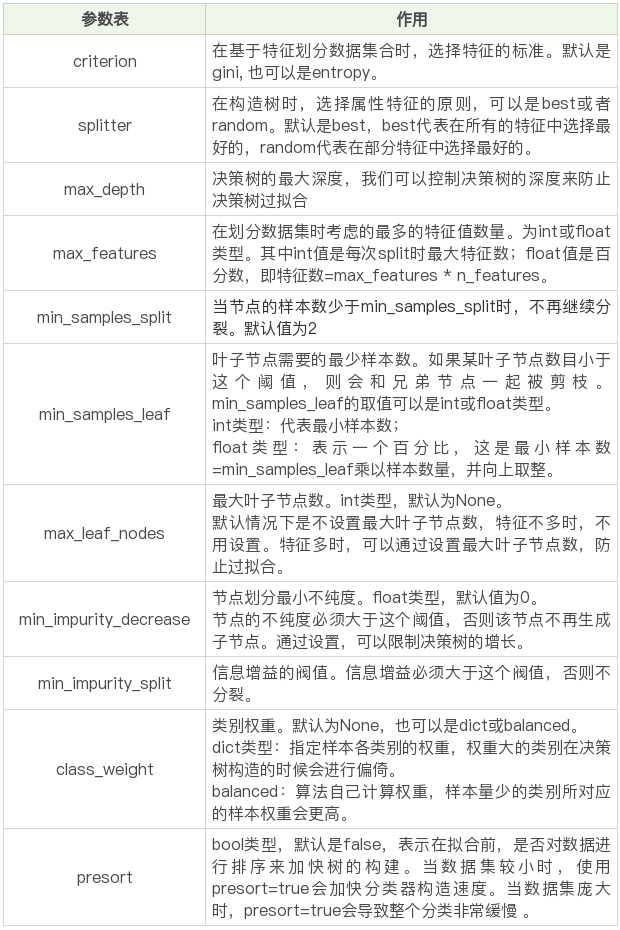

在构造决策树分类器后，我们可以使用 fit 方法让分类器进行拟合，使用 predict 方法对新数据进行预测，得到预测的分类结果，也可以使用 score 方法得到分类器的准确率。下面这个表格是 fit 方法、predict 方法和 score 方法的作用。

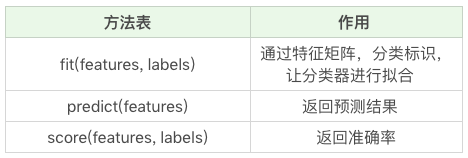

#  Titanic 乘客生存预测

    ***问题描述:***
泰坦尼克海难是著名的十大灾难之一，究竟多少人遇难，各方统计的结果不一。

现在我们可以得到部分的数据，具体数据你可以从 GitHub 上下载：https://github.com/cystanford/Titanic_Data

（完整的项目代码见：https://github.com/cystanford/Titanic_Data/blob/master/titanic_analysis.py 你可以跟着学习后自己练习）


数据集格式为 csv，一共有两个文件：
* train.csv 是训练数据集，包含特征信息和存活与否的标签；
* test.csv: 测试数据集，只包含特征信息。

现在我们需要用决策树分类对训练集进行训练，针对测试集中的乘客进行生存预测，并告知分类器的准确率。在训练集中，包括了以下字段，它们具体为：
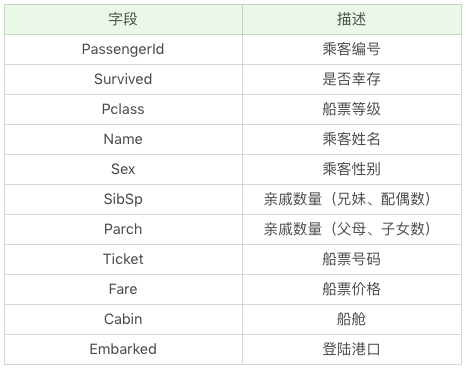

***生存预测的关键流程***

我们要对训练集中乘客的生存进行预测，这个过程可以划分为两个重要的阶段：
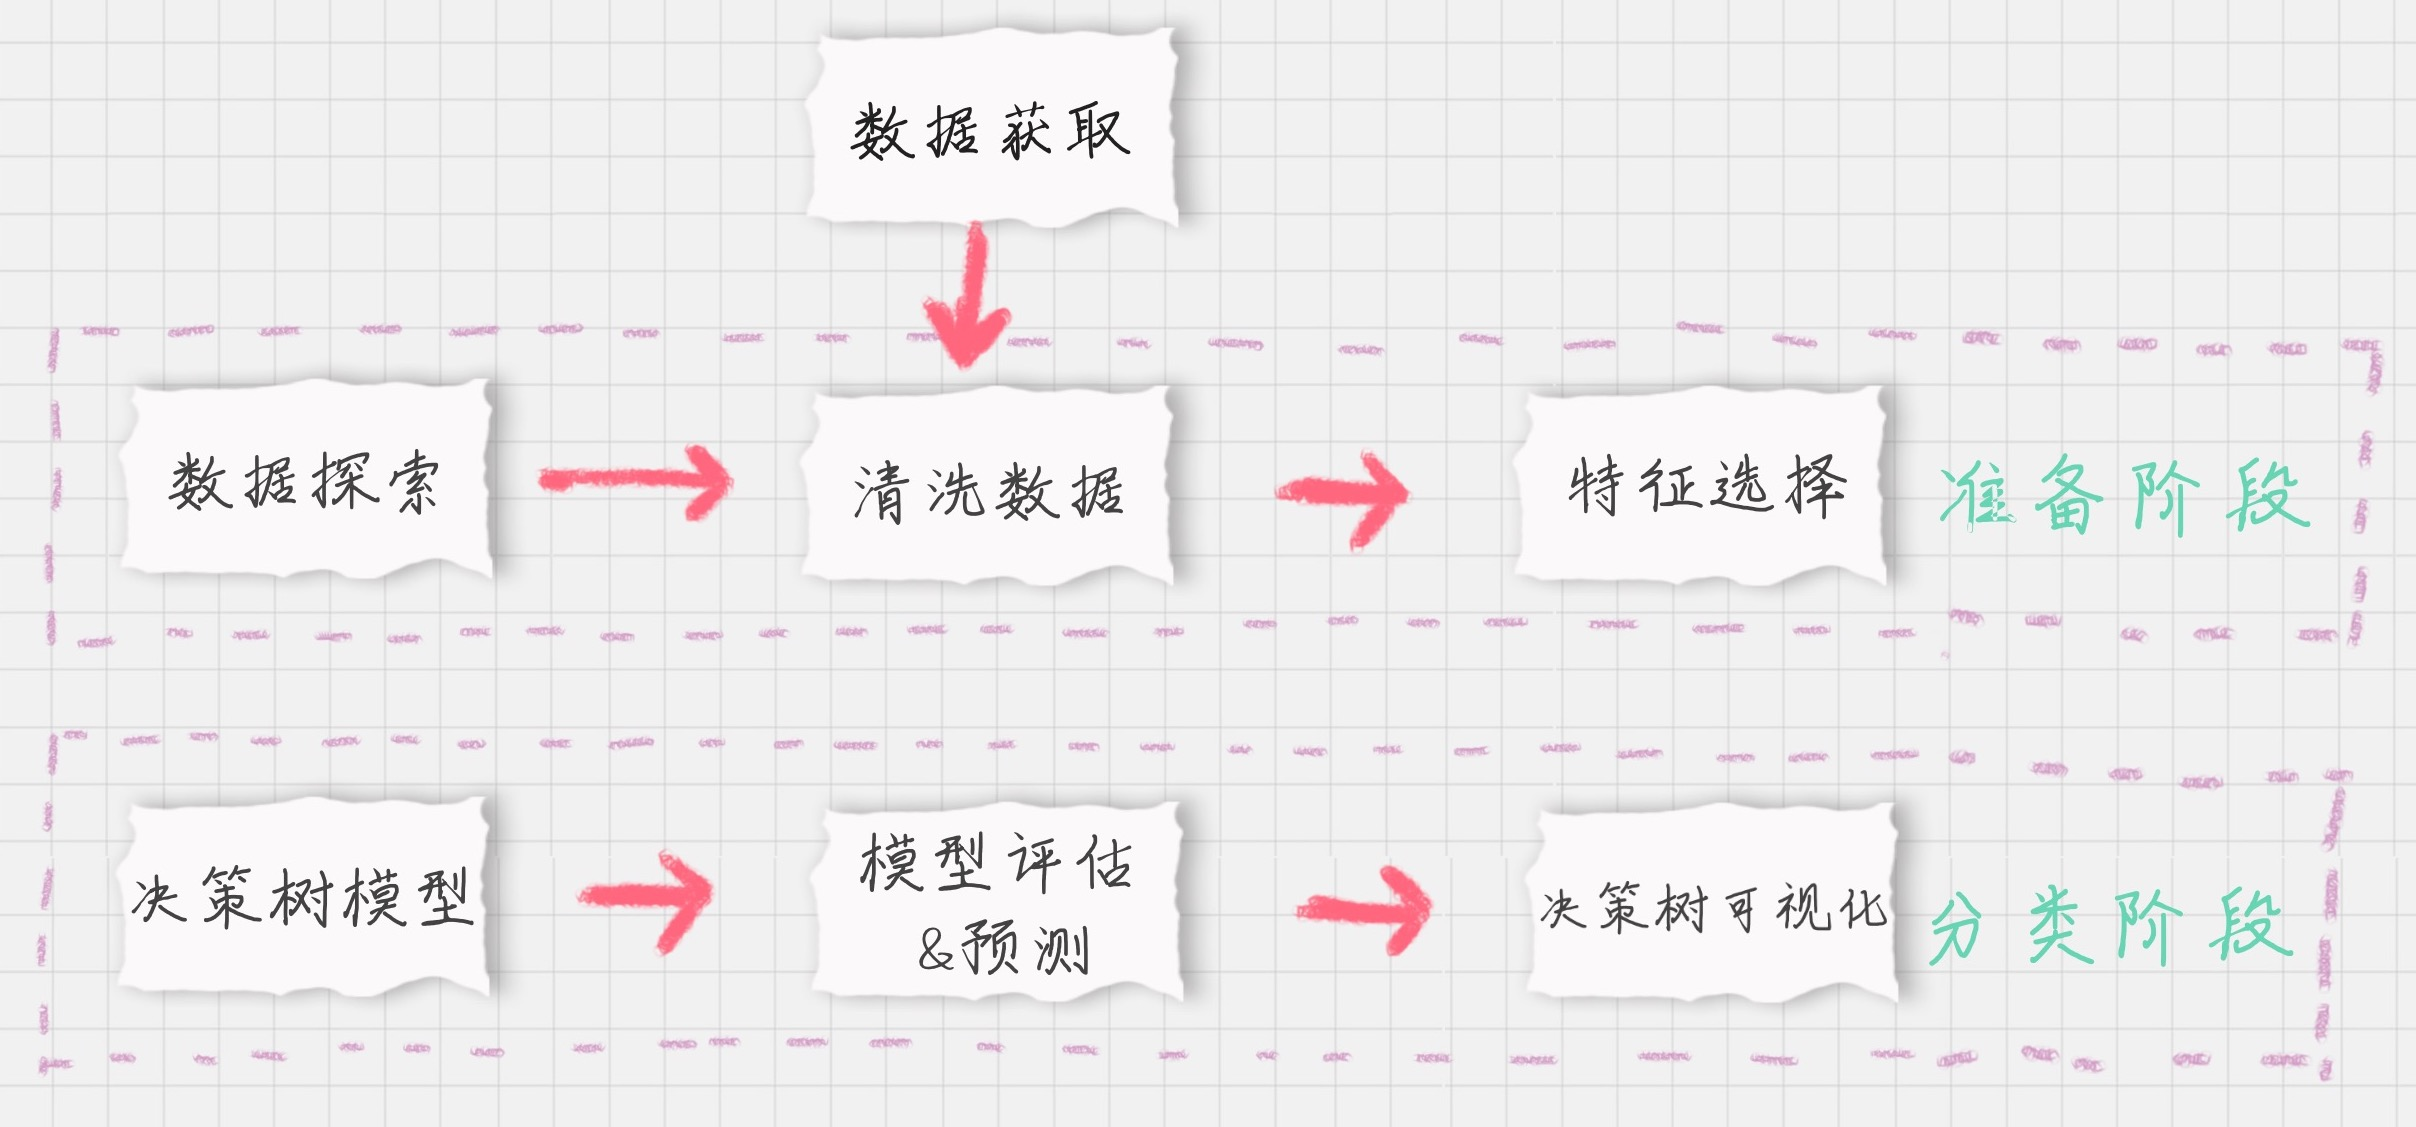

***准备阶段：***我们首先需要对训练集、测试集的数据进行探索，分析数据质量，并对数据进行清洗，然后通过特征选择对数据进行降维，方便后续分类运算；

***分类阶段：***首先通过训练集的特征矩阵、分类结果得到决策树分类器，然后将分类器应用于测试集。然后我们对决策树分类器的准确性进行分析，并对决策树模型进行可视化。

下面，我分别对这些模块进行介绍。

***模块 1：***

    数据探索数据探索这部分虽然对分类器没有实质作用，但是不可忽略。我们只有足够了解这些数据的特性，才能帮助我们做数据清洗、特征选择。这里有一些函数你需要了解：
* 使用 info() 了解数据表的基本情况：行数、列数、每列的数据类型、数据完整度；
* 使用 describe() 了解数据表的统计情况：总数、平均值、标准差、最小值、最大值等；
* 使用 describe(include=[‘O’]) 查看字符串类型（非数字）的整体情况；
* 使用 head 查看前几行数据（默认是前 5 行）；
* 使用 tail 查看后几行数据（默认是最后 5 行）。

In [1]:
import pandas as pd
# 数据加载
train_data = pd.read_csv('./train.csv')
test_data = pd.read_csv('./test.csv')
# 数据探索
print(train_data.info())
print('-'*30)
print(train_data.describe())
print('-'*30)
print(train_data.describe(include=['O']))
print('-'*30)
print(train_data.head())
print('-'*30)
print(train_data.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
------------------------------
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008  

***模块 2：数据清洗***

    通过数据探索，我们发现 Age、Fare 和 Cabin 这三个字段的数据有所缺失。其中 Age 为年龄字段，是数值型，我们可以通过平均值进行补齐；Fare 为船票价格，是数值型，我们也可以通过其他人购买船票的平均值进行补齐。

In [2]:
# 使用平均年龄来填充年龄中的nan值
train_data['Age'].fillna(train_data['Age'].mean(), inplace=True)
test_data['Age'].fillna(test_data['Age'].mean(),inplace=True)
# 使用票价的均值填充票价中的nan值
train_data['Fare'].fillna(train_data['Fare'].mean(), inplace=True)
test_data['Fare'].fillna(test_data['Fare'].mean(),inplace=True)

    Cabin 为船舱，有大量的缺失值。在训练集和测试集中的缺失率分别为 77% 和 78%，无法补齐；Embarked 为登陆港口，有少量的缺失值，我们可以把缺失值补齐。首先观察下 Embarked 字段的取值，方法如下：

In [3]:
print(train_data['Embarked'].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64


    我们发现一共就 3 个登陆港口，其中 S 港口人数最多，占到了 72%，因此我们将其余缺失的 Embarked 数值均设置为 S：

In [4]:
# 使用登录最多的港口来填充登录港口的nan值
train_data['Embarked'].fillna('S', inplace=True)
test_data['Embarked'].fillna('S',inplace=True)

In [5]:
train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000000,1,0,237736,30.0708,NaN,C


***模块 3：特征选择***

    特征选择是分类器的关键。特征选择不同，得到的分类器也不同。那么我们该选择哪些特征做生存的预测呢？

    通过数据探索我们发现，PassengerId 为乘客编号，对分类没有作用，可以放弃；Name 为乘客姓名，对分类没有作用，可以放弃；Cabin 字段缺失值太多，可以放弃；Ticket 字段为船票号码，杂乱无章且无规律，可以放弃。其余的字段包括：Pclass、Sex、Age、SibSp、Parch 和 Fare，这些属性分别表示了乘客的船票等级、性别、年龄、亲戚数量以及船票价格，可能会和乘客的生存预测分类有关系。具体是什么关系，我们可以交给分类器来处理。

    因此我们先将 Pclass、Sex、Age 等这些其余的字段作特征，放到特征向量 features 里。

In [6]:
# 特征选择
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
train_features = train_data[features]
train_labels = train_data['Survived']
test_features = test_data[features]

print(train_features)

     Pclass     Sex        Age  SibSp  Parch     Fare Embarked
0         3    male  22.000000      1      0   7.2500        S
1         1  female  38.000000      1      0  71.2833        C
2         3  female  26.000000      0      0   7.9250        S
3         1  female  35.000000      1      0  53.1000        S
4         3    male  35.000000      0      0   8.0500        S
..      ...     ...        ...    ...    ...      ...      ...
886       2    male  27.000000      0      0  13.0000        S
887       1  female  19.000000      0      0  30.0000        S
888       3  female  29.699118      1      2  23.4500        S
889       1    male  26.000000      0      0  30.0000        C
890       3    male  32.000000      0      0   7.7500        Q

[891 rows x 7 columns]


    特征值里有一些是字符串，这样不方便后续的运算，需要转成数值类型，比如 Sex 字段，有 male 和 female 两种取值。我们可以把它变成 Sex=male 和 Sex=female 两个字段，数值用 0 或 1 来表示。同理 Embarked 有 S、C、Q 三种可能，我们也可以改成 Embarked=S、Embarked=C 和 Embarked=Q 三个字段，数值用 0 或 1 来表示。那该如何操作呢，我们可以使用 sklearn 特征选择中的 DictVectorizer 类，用它将可以处理符号化的对象，将符号转成数字 0/1 进行表示。具体方法如下：

In [7]:
from sklearn.feature_extraction import DictVectorizer
dvec=DictVectorizer(sparse=False)
train_features=dvec.fit_transform(train_features.to_dict(orient='records'))

    你会看到代码中使用了 fit_transform 这个函数，它可以将特征向量转化为特征值矩阵。然后我们看下 dvec 在转化后的特征属性是怎样的，即查看 dvec 的 feature_names_ 属性值，方法如下：

In [8]:
print(dvec.feature_names_)

['Age', 'Embarked=C', 'Embarked=Q', 'Embarked=S', 'Fare', 'Parch', 'Pclass', 'Sex=female', 'Sex=male', 'SibSp']


    你可以看到原本是一列的 Embarked，变成了“Embarked=C”“Embarked=Q”“Embarked=S”三列。Sex 列变成了“Sex=female”“Sex=male”两列。这样 train_features 特征矩阵就包括 10 个特征值（列），以及 891 个样本（行），即 891 行，10 列的特征矩阵。
    
***模块 4：***
    
    决策树模型刚才我们已经讲了如何使用 sklearn 中的决策树模型。现在我们使用 ID3 算法，即在创建 DecisionTreeClassifier 时，设置 criterion=‘entropy’，然后使用 fit 进行训练，将特征值矩阵和分类标识结果作为参数传入，得到决策树分类器。

In [9]:
from sklearn.tree import DecisionTreeClassifier
# 构造ID3决策树
clf = DecisionTreeClassifier(criterion='entropy')
# 决策树训练
clf.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

***模块 5：***

    模型预测 & 评估在预测中，我们首先需要得到测试集的特征值矩阵，然后使用训练好的决策树 clf 进行预测，得到预测结果 pred_labels：

In [10]:
test_features=dvec.transform(test_features.to_dict(orient='records'))
# 决策树预测
pred_labels = clf.predict(test_features)

print(pred_labels)

[0 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 1 1 0
 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 1 1 0 0 1 1 0 0 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0
 0 1 0 1 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 1
 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0
 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 1
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0
 0 0 1 0 1 0 0 1 0 0 0]


    在模型评估中，决策树提供了 score 函数可以直接得到准确率，但是我们并不知道真实的预测结果，所以无法用预测值和真实的预测结果做比较。我们只能使用训练集中的数据进行模型评估，可以使用决策树自带的 score 函数计算下得到的结果：

In [11]:
# 得到决策树准确率
acc_decision_tree = round(clf.score(train_features, train_labels), 6)
print(u'score准确率为 %.4lf' % acc_decision_tree)

score准确率为 0.9820


你会发现你刚用训练集做训练，再用训练集自身做准确率评估自然会很高。但这样得出的准确率并不能代表决策树分类器的准确率。这是为什么呢？

因为我们没有测试集的实际结果，因此无法用测试集的预测结果与实际结果做对比。如果我们使用 score 函数对训练集的准确率进行统计，正确率会接近于 100%（如上结果为 98.2%），无法对分类器的在实际环境下做准确率的评估。那么有什么办法，来统计决策树分类器的准确率呢？

这里可以使用 K 折交叉验证的方式，交叉验证是一种常用的验证分类准确率的方法，原理是拿出大部分样本进行训练，少量的用于分类器的验证。
K 折交叉验证，就是做 K 次交叉验证，每次选取 K 分之一的数据作为验证，其余作为训练。轮流 K 次，取平均值。

K 折交叉验证的原理是这样的：
* 1、将数据集平均分割成 K 个等份；
* 2、使用 1 份数据作为测试数据，其余作为训练数据；
* 3、计算测试准确率；
* 4、使用不同的测试集，重复 2、3 步骤。

在 sklearn 的 model_selection 模型选择中提供了``` cross_val_score ```函数。cross_val_score 函数中的参数 cv 代表对原始数据划分成多少份，也就是我们的 K 值，一般建议 K 值取 10，因此我们可以设置 CV=10，我们可以对比下 score 和 cross_val_score 两种函数的正确率的评估结果：

In [12]:
import numpy as np
from sklearn.model_selection import cross_val_score
# 使用K折交叉验证 统计决策树准确率
print(u'cross_val_score准确率为 %.4lf' % np.mean(cross_val_score(clf, train_features, train_labels, cv=10)))

cross_val_score准确率为 0.7791


    你可以看到，score函数的准确率为 0.9820，cross_val_score 准确率为 0.7835。这里很明显，对于不知道测试集实际结果的，要使用 K 折交叉验证才能知道模型的准确率。

***模块 6：***

决策树可视化sklearn 的决策树模型对我们来说，还是比较抽象的。我们可以使用 Graphviz 可视化工具帮我们把决策树呈现出来。
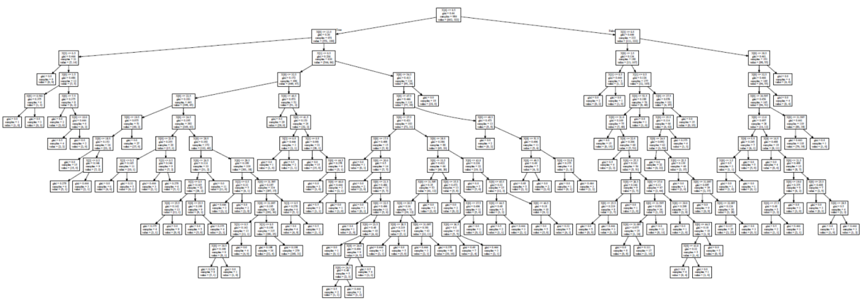

安装 Graphviz 库需要下面的几步：
* 1、安装 graphviz 工具，这里是它的下载地址；http://www.graphviz.org/download/
* 2、将 Graphviz 添加到环境变量 PATH 中；
* 3、需要 Graphviz 库，如果没有可以使用 pip install graphviz 进行安装。

这样你就可以在程序里面使用 Graphviz 对决策树模型进行呈现，最后得到一个决策树可视化的 PDF 文件，可视化结果文件 Source.gv.pdf 你可以在 GitHub 上下载：https://github.com/cystanford/Titanic_Data

In [14]:
from sklearn import tree
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None)
graph = graphviz.Source(dot_data)
graph.render("决策树可视化")
graph.view('graph')

'graph.pdf'

***决策树模型使用技巧总结***

在实战中，你需要注意一下几点：

* 1、特征选择是分类模型好坏的关键。选择什么样的特征，以及对应的特征值矩阵，决定了分类模型的好坏。通常情况下，特征值不都是数值类型，可以使用 DictVectorizer 类进行转化；

* 2、模型准确率需要考虑是否有测试集的实际结果可以做对比，当测试集没有真实结果可以对比时，需要使用 K 折交叉验证 cross_val_score；

* 3、Graphviz 可视化工具可以很方便地将决策模型呈现出来，帮助你更好理解决策树的构建。

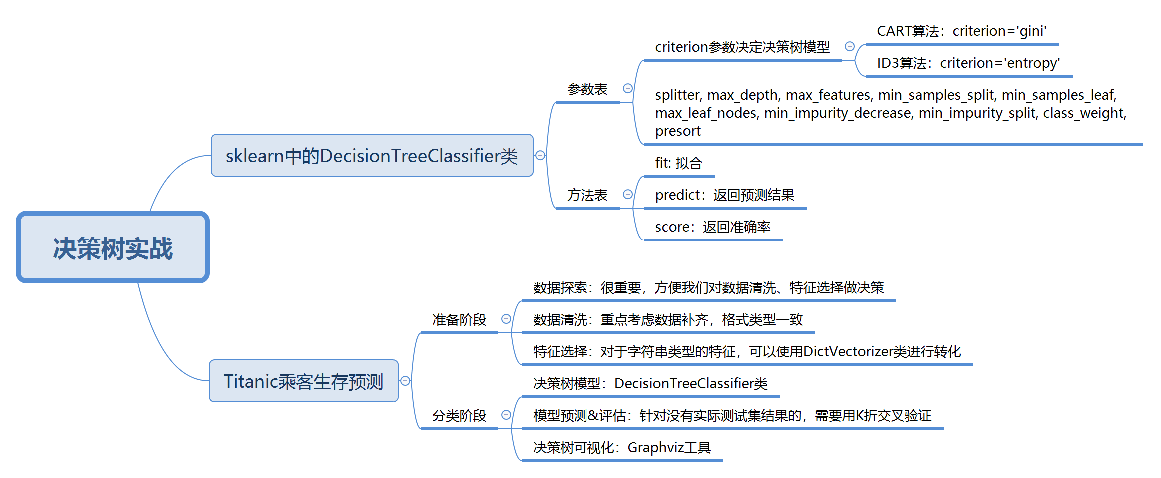

我上面讲了泰坦尼克乘客生存预测的六个关键模块，请你用 sklearn 中的决策树模型独立完成这个项目，对测试集中的乘客是否生存进行预测，并给出模型准确率评估。

最后给你留一个思考题吧，我在构造特征向量时使用了 DictVectorizer 类，使用 fit_transform 函数将特征向量转化为特征值矩阵。DictVectorizer 类同时也提供 transform 函数，那么这两个函数有什么区别？

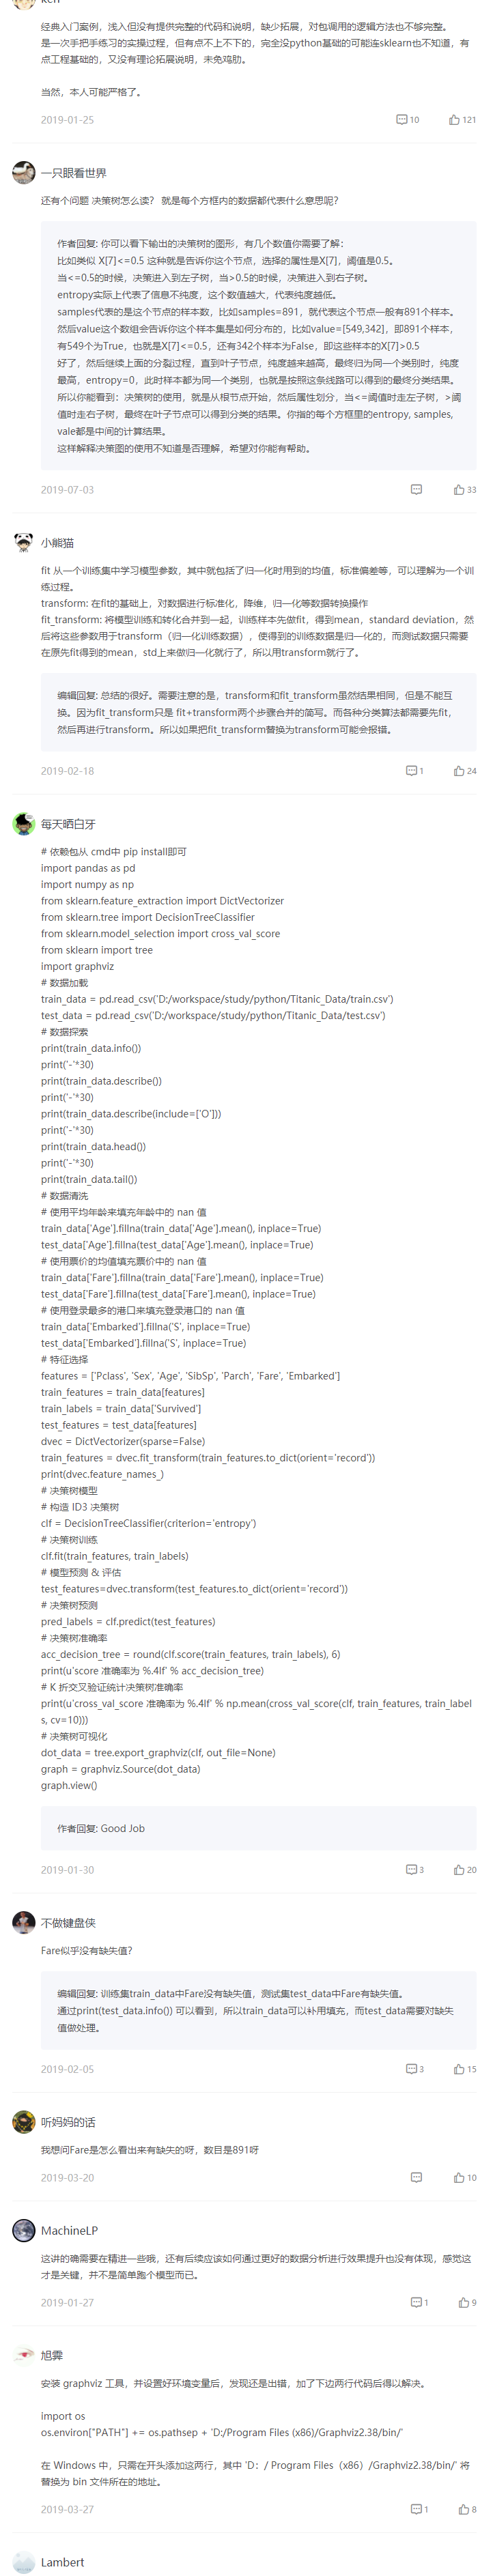